$\newcommand{\EE}{\mathbb{E}}$

# Example: The Kalman Filter

A famous example for timeseries model is the Kalman Filter (and also Smoother). Inference and learning with this model requires exactly the features, that `GT` leverages. Let's see that in a bit more detail. 

The Kalman Filter is a two layered model described by the following equations: 

$$
\color{red}{Z_{t} = A Z_{t-1} + b + \zeta_t} \\
\color{blue}{X_{t} = C Z_t + d + \xi_t},
$$

where $X_t$ are our observations and $Z_t$ latent (unobserved) variables. Furthermore, the noise variables are

$$
\color{red}{\zeta_t \sim N(0,Q_z)}\\
\color{blue}{\xi_t \sim N(0,Q_x)}.
$$

Hence, our model is composed by a $\color{red}{\text{state model}}$ and an $\color{blue}{\text{emission- or observation model}}$.

The joint likelihood is given by

$$
p(Z_{0:T}, X_{1:T}\vert w) = p(Z_0\vert w)\prod_{t=0}^{T-1} \color{blue}{p(X_{t}\vert Z_{t}, w)}\color{red}{p(Z_{t}\vert Z_{t-1}, w)}.
$$


## Inference

We call inference getting the posterior over the latent variables $Z_{0:T}$ given a set of observations $X_{1:T}$. For the Kalman filter this is done in a two-step procedure.

### Filter procedure:

Assume that you have the estimate for $\color{darkorange}{p(Z_t\vert X_{1:t})}$.

+ Prediction step:

$$
 \color{green}{p(Z_{t+1}\vert X_{1:t})} = \int \color{red}{p(Z_{t+1}Z_t)}\color{darkorange}{p(Z_t\vert X_{1:t})}\diff Z_t
$$

Has the form of an _affine marginal transformation_ $T_{\rm marg}[p(Y|X),p(X)] = p(Y)$.

+ Filter step:

$$
 \color{darkorange}{p(Z_{t+1}\vert X_{1:t+1})} = \frac{\color{blue}{p(X_{t+1}|Z_{t+1})}\color{green}{p(Z_{t+1}\vert X_{1:t})}}{\int \color{blue}{p(X_{t+1}|Z^\prime_{t+1})}\color{green}{p(Z^\prime_{t+1}\vert X_{1:t})}{\rm d} Z^\prime_{t+1}}
$$


Hase the form of a _affine conditional transformation_: $T_{\rm cond}[p(Y|X),p(X)] = p(X\vert Y)$. This procedure can iterate forward through time.

### Smoothing procedure:

_Smoothing_ is called the backward iteration through time, which yields the density over the trajectories of the latent variables $Z_{0:T}$ given all observations (past __and__ future). This involves also just affine transformations for the Kalman Filter.

Let's generate some example data, to show case how this is done in the `GT`.

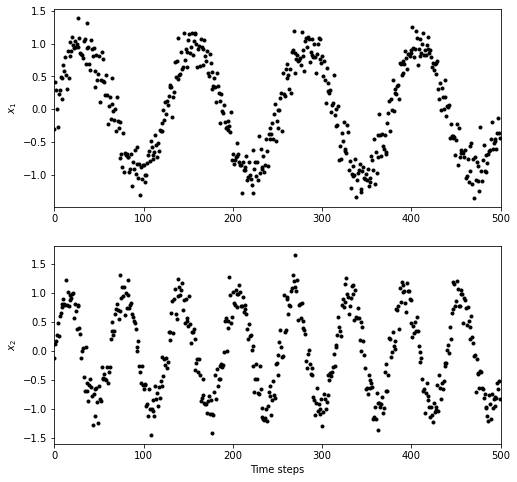

In [29]:
from jax import numpy as jnp
import objax
from matplotlib import pyplot as plt

T = 500
trange = jnp.arange(T)
Dx = 2
Dz = 2
X = jnp.empty((T,Dx))
X = X.at[:,0].set(jnp.sin(trange / 20))
X = X.at[:,1].set(jnp.sin(trange / 10))
noise_x = .2
noise_z = .1
X += noise_x * objax.random.normal(X.shape)

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.plot(X[:,0], 'k.')
plt.xlim([0,500])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.show()

### Implementation in `GT`

`GT` provides a `timeseries` module, where a couple of `state_model`s and `observation_model`s and are implemented. They all can be combined to construct different state-space models, and all their parameters can be learnt via an EM procedure (exact or in some cases approximate).

Let's see how this is working for the Kalman filter.

We previously saw that the state and observation model are both linear for the Kalman filter. Hence, we will create a `LinearStateModel` and `LinearObservationModel`, and combine them to a `StateSpaceModel`.

In [32]:
from gaussian_toolbox.timeseries import observation_model, state_model, ssm_em

Dz = 2
Dx = X.shape[1]

om = observation_model.LinearObservationModel(Dx=Dx, Dz=Dz)
sm = state_model.LinearStateModel(Dz=Dz, noise_z=.5)

ssm = ssm_em.StateSpaceEM(X, om, sm)

Now let's perform filtering (`forward_path`) and smoothing (`backward_path`) on the training data.

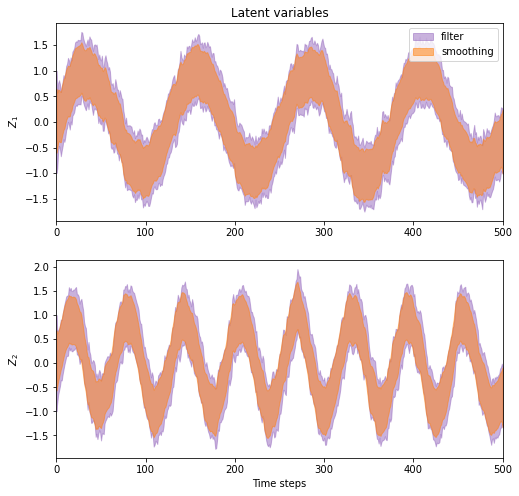

In [40]:
ssm.forward_path()

filter_mean = ssm.filter_density.mu
filter_std = jnp.sqrt(ssm.filter_density.Sigma.diagonal(axis1=1, axis2=2))

ssm.backward_path()

smoothing_mean = ssm.smoothing_density.mu
smoothing_std = jnp.sqrt(ssm.smoothing_density.Sigma.diagonal(axis1=1, axis2=2))


plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.fill_between(range(0,T+1), filter_mean[:,0] - filter_std[:,0], filter_mean[:,0] + filter_std[:,0], alpha=.5, label='filter', color='C4')
plt.fill_between(range(0,T+1), smoothing_mean[:,0] - smoothing_std[:,0], smoothing_mean[:,0] + smoothing_std[:,0], alpha=.5, label='smoothing', color='C1')
plt.xlim([0,500])
plt.ylabel('$Z_1$')
plt.legend()
plt.title('Latent variables')
plt.subplot(212, sharex=ax1)
plt.fill_between(range(0,T+1), filter_mean[:,1] - filter_std[:,1], filter_mean[:,1] + filter_std[:,1], alpha=.5, color='C4')
plt.fill_between(range(0,T+1), smoothing_mean[:,1] - smoothing_std[:,1], smoothing_mean[:,1] + smoothing_std[:,1], alpha=.5, color='C1')
plt.xlabel('Time steps')
plt.ylabel('$Z_2$')
plt.show()

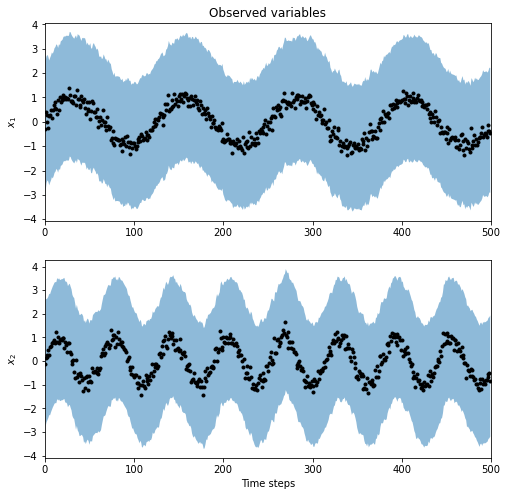

In [37]:
p_x = ssm.compute_data_density()
mean_estimate = p_x.mu
std_estimate = 2 * jnp.sqrt(p_x.Sigma.diagonal(axis1=1, axis2=2))

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.title('Observed variables')
plt.plot(X[:,0], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,0] - std_estimate[1:,0], mean_estimate[1:,0] + std_estimate[1:,0], alpha=.5)
plt.xlim([0,500])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,1] - std_estimate[1:,1], mean_estimate[1:,1] + std_estimate[1:,1], 
                    alpha=.5)
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.show()

## Learning parameters with Expectation Maximization

We do not maximize the likelihood $p(x_{1:T}\vert w)$, but the Q-function which is defined as 

$$
 Q(\theta,\theta^{\rm old}) = \EE_{p(z_{0:t}\vert x_{1:T}, \theta^{\rm old})}\left[\ln p(z_{0:T}, x_{1:T}\vert \theta)\right] \leq \ln p(x_{1:T}\vert \theta).
$$

This nicely decomposes into

$$
    Q(\theta,\theta^{\rm old}) = \sum_{t=1}^T\EE_{p(z_t\vert x_{1:T}, \theta^{\rm old})}\left[\ln \color{blue}{p(x_t\vert z_{t}, \theta)}\right] + \sum_{t=1}^T\EE_{p(z_{t-1:t}\vert x_{1:T}, \theta^{\rm old})}\left[\ln \color{red}{p(z_t\vert z_{t-1},\theta)}\right] + \EE_{p(z_0\vert x_{1:T}, \theta^{\rm old})}\left[\ln p(z_0\vert \theta)\right].
$$

__Important observation__: $\color{blue}{\text{Observation model}}$ and $\color{red}{\text{state model}}$ are always decoupled!

```p_X.integrate('...')``` function is very useful to compute the Q-function easily.

EM did converge.


Text(0, 0.5, 'Log likelihood')

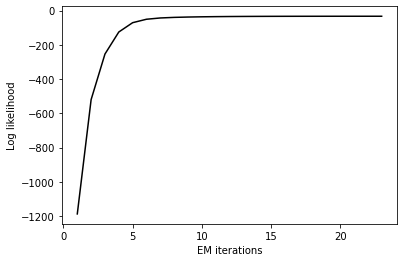

In [43]:
ssm.run()
plt.plot(jnp.arange(1, len(ssm.llk_list) + 1), ssm.llk_list, 'k')
plt.xlabel('EM iterations')
plt.ylabel('Log likelihood')

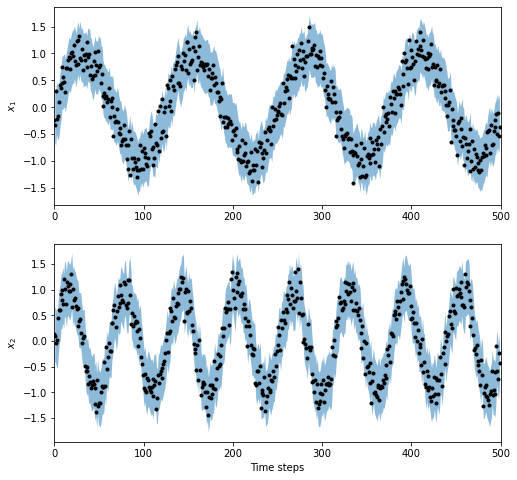

In [26]:
p_x = ssm.compute_data_density() # int p(x|z)p(z)dz
mean_estimate = p_x.mu
std_estimate = 2 * jnp.sqrt(p_x.Sigma.diagonal(axis1=1, axis2=2))

plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
plt.plot(X[:,0], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,0] - std_estimate[1:,0], mean_estimate[1:,0] + std_estimate[1:,0], alpha=.5)
plt.xlim([0,500])
plt.ylabel('$x_1$')
plt.subplot(212, sharex=ax1)
plt.plot(X[:,1], 'k.')
plt.fill_between(range(1,T), mean_estimate[1:,1] - std_estimate[1:,1], mean_estimate[1:,1] + std_estimate[1:,1], 
                    alpha=.5)
plt.xlabel('Time steps')
plt.ylabel('$x_2$')
plt.show()